In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [42]:
def loss_fn(output, target):
    pitch_loss = nn.CrossEntropyLoss()(
        output['pitch'].reshape(-1, output['pitch'].shape[-1]),
        target[:, :, 0].reshape(-1).long()  # <-- cast to long
    )
    mse_loss = nn.MSELoss()
    
    velocity_loss = mse_loss(
        output['velocity'].reshape(-1, output['velocity'].shape[-1]),
        target[:, :, 1].reshape(-1, 1)
    )
    time_loss = mse_loss(
        output['time'].reshape(-1, output['time'].shape[-1]),
        target[:, :, 2].reshape(-1, 1)
    )
    duration_loss = mse_loss(
        output['duration'].reshape(-1, output['duration'].shape[-1]),
        target[:, :, 3].reshape(-1, 1)
    )

    return pitch_loss + velocity_loss * 350 + time_loss * 65 + duration_loss * 50


In [3]:
from src.models.GRU import GRUAutoencoder
from src.dataloader import EventMidiDataset

In [4]:
import os
from tqdm import tqdm

In [5]:
folder_path = 'data/midi_dataset/midis'
file_names = os.listdir(folder_path)
file_names = [os.path.join(folder_path, f) for f in file_names]

In [51]:
model = GRUAutoencoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
dataset = EventMidiDataset(file_names[:1000])
val_ds = EventMidiDataset(file_names[1000:1100])


In [46]:
midi_dataloader = DataLoader(
    dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=6,
    shuffle=False,
)
val_dl = DataLoader(
    val_ds,
    batch_size=64,
    pin_memory=True,
    num_workers=6,
    shuffle=False,
)

In [ ]:
# max_vals = None
# min_vals = None

# for X_batch in midi_dataloader:
#     batch_max = X_batch.view(-1, X_batch.shape[-1]).max(dim=0).values
#     batch_min = X_batch.view(-1, X_batch.shape[-1]).min(dim=0).values

#     if max_vals is None:
#         max_vals = batch_max
#         min_vals = batch_min
#     else:
#         max_vals = torch.max(max_vals, batch_max)
#         min_vals = torch.min(min_vals, batch_min)

# print("Max values across all batches (pitch, velocity, time, duration):", max_vals)
# print("Min values across all batches (pitch, velocity, time, duration):", min_vals)


Max values across all batches (pitch, velocity, time, duration): tensor([83.0000,  0.9370,  0.9161,  0.8579])
Min values across all batches (pitch, velocity, time, duration): tensor([0.0000, 0.0315, 0.0000, 0.0002])


In [47]:
def fit(dataloader, val_dataloader, model, optimizer, loss_fn, epochs=50, patience=5, best_model_path='best_model.pt'):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        total_train_loss = 0.0
        for X_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            X_batch = X_batch.cuda()

            input_seq = X_batch[:, :-1]
            target_seq = X_batch[:, 1:]

            logits = model(input_seq)
            loss = loss_fn(logits, target_seq)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(dataloader)

        # ---- Validation ----
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for X_batch in val_dataloader:
                X_batch = X_batch.cuda()

                input_seq = X_batch[:, :-1]
                target_seq = X_batch[:, 1:]

                logits = model(input_seq)
                loss = loss_fn(logits, target_seq)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)

        # ---- Print epoch results ----
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # ---- Early stopping and saving best model ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            # print(f"Best model saved at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

In [52]:
fit(midi_dataloader, val_dl, model, optimizer, loss_fn, 10)

Epoch 1/10 - Training:   0%|          | 0/5806 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002490F6D0900>
Traceback (most recent call last):
  File "c:\Users\PC\Desktop\bartek\MidiRepGen\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\PC\Desktop\bartek\MidiRepGen\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Epoch 1/10 - Training: 100%|██████████| 5806/5806 [01:03<00:00, 91.38it/s] 


Epoch 1: Train Loss = 6.1837, Val Loss = 5.4106


Epoch 2/10 - Training: 100%|██████████| 5806/5806 [00:59<00:00, 96.85it/s] 


Epoch 2: Train Loss = 4.4365, Val Loss = 3.9420


Epoch 3/10 - Training: 100%|██████████| 5806/5806 [01:02<00:00, 93.56it/s] 


Epoch 3: Train Loss = 3.5978, Val Loss = 3.2319


Epoch 4/10 - Training: 100%|██████████| 5806/5806 [01:02<00:00, 92.71it/s] 


Epoch 4: Train Loss = 2.8852, Val Loss = 2.5228


Epoch 5/10 - Training: 100%|██████████| 5806/5806 [01:08<00:00, 85.20it/s] 


Epoch 5: Train Loss = 2.2809, Val Loss = 2.1980


Epoch 6/10 - Training: 100%|██████████| 5806/5806 [01:14<00:00, 77.59it/s] 


Epoch 6: Train Loss = 1.8940, Val Loss = 1.9060


Epoch 7/10 - Training: 100%|██████████| 5806/5806 [01:09<00:00, 84.10it/s] 


Epoch 7: Train Loss = 1.6336, Val Loss = 1.6387


Epoch 8/10 - Training: 100%|██████████| 5806/5806 [01:09<00:00, 83.60it/s] 


Epoch 8: Train Loss = 1.4384, Val Loss = 1.4947


Epoch 9/10 - Training: 100%|██████████| 5806/5806 [01:01<00:00, 94.63it/s] 


Epoch 9: Train Loss = 1.2873, Val Loss = 1.3212


Epoch 10/10 - Training: 100%|██████████| 5806/5806 [01:09<00:00, 83.97it/s] 


Epoch 10: Train Loss = 1.1702, Val Loss = 1.2319


In [ ]:
test_dataset = EventMidiDataset(file_names[1100:1200])


In [53]:
test_dl = DataLoader(
    dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=6,
    shuffle=True,
)

In [54]:
total_loss = 0
num_batches = 0

model.eval()
with torch.no_grad():
    for X_batch in test_dl:
        X_batch = X_batch.cuda()
        input_seq = X_batch[:, :-1]
        target_seq = X_batch[:, 1:]

        output = model(input_seq)
        loss = loss_fn(output, target_seq)

        total_loss += loss.item()
        num_batches += 1

avg_loss = total_loss / num_batches
print(f"Average Test Loss: {avg_loss:.4f}")

Average Test Loss: 1.2089


In [55]:
sample = test_dataset[0]  # shape: (seq_len, 4)
sample = sample.unsqueeze(0).cuda()  # Add batch dimension → shape: (1, seq_len, 4)

In [57]:
sample = dataset[0]  # shape: (seq_len, 4)
sample = sample.unsqueeze(0).cuda()  # Add batch dimension → shape: (1, seq_len, 4)

torch.Size([1, 10]) torch.Size([1, 10]) torch.Size([1, 10]) torch.Size([1, 10])
Original vs Reconstructed (first 10 steps):
00: Orig: [2.3000000e+01 5.7480317e-01 2.3641747e-03 7.2358631e-02]  |  Recon: [6.2000000e+01 7.4251431e-01 1.8001013e-03 5.6747027e-02]
01: Orig: [6.2000000e+01 6.6141731e-01 5.1062093e-06 7.2172619e-02]  |  Recon: [2.6000000e+01 4.4993621e-01 5.7631545e-04 4.5113660e-02]
02: Orig: [2.6000000e+01 4.9606299e-01 3.5743462e-05 9.3005953e-04]  |  Recon: [5.4000000e+01 4.3073621e-01 3.0959491e-04 5.8277868e-02]
03: Orig: [5.4000000e+01 4.8818898e-01 0.0000000e+00 4.2224701e-02]  |  Recon: [3.0000000e+01 5.5627227e-01 2.6838947e-04 5.4552533e-02]
04: Orig: [3.0000000e+01 5.4330707e-01 5.6168303e-04 7.3288687e-02]  |  Recon: [5.9000000e+01 6.7143667e-01 7.4121542e-04 2.9220484e-02]
05: Orig: [5.9000000e+01 6.1417323e-01 2.5531046e-05 7.2358631e-02]  |  Recon: [ 5.4000000e+01  4.9034241e-01 -4.4197589e-04  1.5913382e-02]
06: Orig: [5.4000000e+01 5.3543305e-01 5.9742649e-

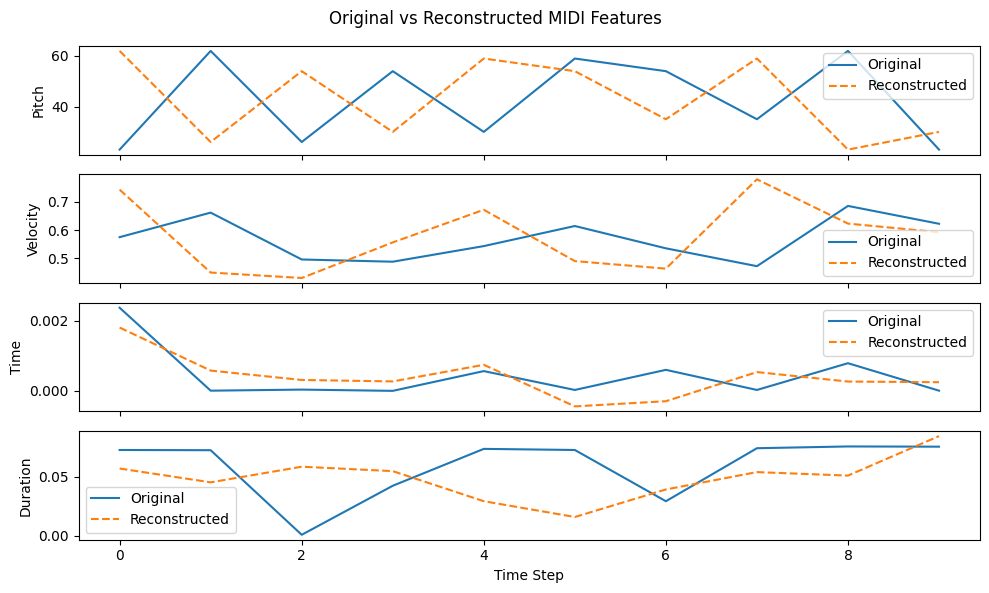

In [58]:
model.eval()
with torch.no_grad():
    reconstructed = model(sample)
reconstructed_pitch = torch.argmax(reconstructed['pitch'], dim=-1)
reconstructed_velocity = reconstructed['velocity'].squeeze(-1)
reconstructed_time = reconstructed['time'].squeeze(-1)
reconstructed_duration = reconstructed['duration'].squeeze(-1)

print(reconstructed_pitch.shape, reconstructed_velocity.shape, reconstructed_time.shape, reconstructed_duration.shape)

reconstructed_seq = torch.stack([
    reconstructed_pitch,
    reconstructed_velocity,
    reconstructed_time,
    reconstructed_duration
], dim=-1).squeeze(0)
print("Original vs Reconstructed (first 10 steps):")
for i in range(10):
    orig = sample[0, i].cpu().numpy()
    recon = reconstructed_seq[i].cpu().numpy()
    print(f"{i:02d}: Orig: {orig}  |  Recon: {recon}")
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
labels = ["Pitch", "Velocity", "Time", "Duration"]

for i in range(4):
    axs[i].plot(sample[0, :, i].cpu(), label="Original")
    axs[i].plot(reconstructed_seq[:, i].cpu(), label="Reconstructed", linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()

plt.xlabel("Time Step")
plt.suptitle("Original vs Reconstructed MIDI Features")
plt.tight_layout()
plt.show()
